# Back Propagation from Scratch
#### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms
from sklearn import preprocessing

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(),  download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

#### Relavent functions

In [ ]:
def convert_to_onehot(labels,num_classes):
    output = np.eye(num_classes)[np.array(labels).reshape(-1)]
    return output.reshape(list(np.shape(labels))+[num_classes])

We use non-linear activation functions sigmoid, ReLU, tanh and linear activation function softmax here.

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def tanh(x):
    y=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    return y

In [ ]:
def sigmoid_derivative(x):
    return sigmoid(x) * (1- sigmoid(x))

def relu_derivative(x):
    return x>0

def softmax_derivative(x):
    return softmax(x)*(1-softmax(x))

def tanh_derivative(x):
    y=tanh(x)
    return (1-y**2)

We initialise weights of the weight matrices using Glorot Initialization

In [ ]:
def initialize_weights(No,Ni):
    M=np.sqrt(6/(Ni+No))
    weights=np.asarray(np.random.uniform(-M, M, (No, Ni)), dtype=np.float64)
    biases  = np.zeros((No,1))
    return weights,biases

In [ ]:
def initialize_parameters(layers_dims):
    parameters = {}
    for l in range(1, len(layers_dims)):
        parameters['W' + str(l)], parameters['b' + str(l)] = initialize_weights(layers_dims[l],layers_dims[l-1])
    return parameters

#### Forward Propagation

In [ ]:
def linear_activation_forward(A_prev, W, b, activation):

    Z = np.dot(W,A_prev) + b
    cache = (A_prev, W, b)
    linear_cache = A_prev, W, b

    if activation == "sigmoid":
        A = sigmoid(Z) # This "activation_cache" contains "Z"
    
    elif activation == "relu":
        A = relu(Z) # This "activation_cache" contains "Z"

    elif activation == "tanh":
        A = tanh(Z) # This "activation_cache" contains "Z"
    
    elif activation == "softmax":
        A = softmax(Z) # This "activation_cache" contains "Z"

    activation_cache = Z
    cache = (linear_cache, activation_cache)

    return A, cache


In [ ]:
def forward_propagation(X,parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network

    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "softmax")
    caches.append(cache)
    return AL, caches

#### Cost funtion
The cross entropy loss is used here

In [ ]:
def compute_cost(AL, Y):    
    #A is predicted
    #Y is actual
    m = Y.shape[1] 
    cost = (-1/m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply((1-Y), np.log(1-AL)))
    return cost

#### Back propagation

In [ ]:
def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [ ]:
def linear_activation_backward(dZ, dA, cache, activation):

    linear_cache, activation_cache = cache
    Z = activation_cache
    if activation == "relu":
        dZ = np.multiply(dA, relu_derivative(Z))
        
    elif activation == "sigmoid":
        dZ = np.multiply(dA, sigmoid_derivative(Z))

    elif activation == "tanh":
        dZ = np.multiply(dA, tanh_derivative(Z))
    
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [ ]:
def compute_grads(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    dAL = AL - Y 
    current_cache = caches[L-1] # Last Layer
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, dAL, current_cache, "softmax")
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward((dAL - Y), grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

In [ ]:
def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

#### Evaluation metrics

In [ ]:
def find_accuracy(y_actual,y_pred):
    accuracy = np.count_nonzero(np.argmax(y_pred,axis=0)==np.argmax(y_actual,axis=1))/y_actual.shape[0]
    return accuracy

In [ ]:
def predict(X,Y,parameters):
    y_pred,cache=forward_propagation(X,parameters)
    return y_pred

### Implemetation of the model

In [ ]:
input_size = 784 # 28x28
layers_dim = [784,500,250,100,10]
num_classes = 10
num_epochs = 15
batch_size = 64
learning_rate = 0.01

In [ ]:
def model1(dataset,layers_dims,num_epochs):
    m=len(dataset)
    num_batches=m/batch_size
    parameters=initialize_parameters(layers_dims)
    costs=[]
    acc=[]
    for epoch in range(num_epochs):
      
        for i in range(int(num_batches)):
            # Data loader
            loader = torch.utils.data.DataLoader(dataset=dataset,batch_size = batch_size ,shuffle=True)
            dataiter = iter(loader)
            data = next(dataiter)
            X,y = data
            X=X.numpy()
            y=y.numpy()
            # Flatten the images
            image_vector_size = 28*28
            X = X.reshape(X.shape[0], image_vector_size)
            y_one_hot=convert_to_onehot(y,10)
            y_pred,cache=forward_propagation(X.T,parameters)
            cost=compute_cost(y_pred,y_one_hot.T)
            gradients=compute_grads(y_pred, y_one_hot.T,cache)
            parameters=update_parameters(parameters,gradients,learning_rate)
            if i%200==0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{int(num_batches)}], Loss: {cost.item():.4f}')
                costs.append(cost)
                acc.append(find_accuracy(y_one_hot,y_pred))
    return acc,costs,parameters

In [ ]:
layers_dims=[784,500,250,100,10]
train_acc,train_costs,trained_parameters=model1(train_dataset,layers_dims,num_epochs)

Epoch [1/15], Step [1/937], Loss: 3.3422
Epoch [1/15], Step [201/937], Loss: 1.6048
Epoch [1/15], Step [401/937], Loss: 0.8061
Epoch [1/15], Step [601/937], Loss: 0.7561
Epoch [1/15], Step [801/937], Loss: 0.4362
Epoch [2/15], Step [1/937], Loss: 0.7366
Epoch [2/15], Step [201/937], Loss: 0.9104
Epoch [2/15], Step [401/937], Loss: 0.6356
Epoch [2/15], Step [601/937], Loss: 0.6003
Epoch [2/15], Step [801/937], Loss: 0.5701
Epoch [3/15], Step [1/937], Loss: 0.4153
Epoch [3/15], Step [201/937], Loss: 0.3466
Epoch [3/15], Step [401/937], Loss: 0.5988
Epoch [3/15], Step [601/937], Loss: 0.5083
Epoch [3/15], Step [801/937], Loss: 0.2742
Epoch [4/15], Step [1/937], Loss: 0.2608
Epoch [4/15], Step [201/937], Loss: 0.4161
Epoch [4/15], Step [401/937], Loss: 0.4532
Epoch [4/15], Step [601/937], Loss: 0.2739
Epoch [4/15], Step [801/937], Loss: 0.3328
Epoch [5/15], Step [1/937], Loss: 0.4891
Epoch [5/15], Step [201/937], Loss: 0.2155
Epoch [5/15], Step [401/937], Loss: 0.3687
Epoch [5/15], Step [6

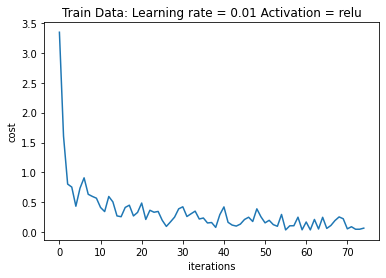

In [ ]:
plt.plot(train_costs)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Train Data: Learning rate = "  + str(learning_rate) + " Activation = "+ "relu")
plt.show()

In [ ]:
p=len(test_dataset)

loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size = p ,shuffle=True)
dataiter = iter(loader)
data = next(dataiter)
X,y = data

X=X.numpy()
y=y.numpy()
# Flatten the images
image_vector_size = 28*28
X = X.reshape(X.shape[0], image_vector_size)
y_one_hot=convert_to_onehot(y,10)
y_pred,cache=forward_propagation(X.T,trained_parameters)
cost=compute_cost(y_pred,y_one_hot.T)

test_accuracy=find_accuracy(y_one_hot,y_pred)
test_cost=compute_cost(y_pred,y_one_hot.T)

Text(51.0, 0.5, 'truth')

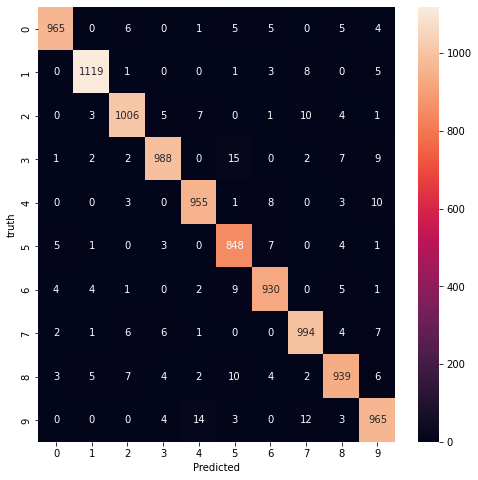

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
k = np.argmax(y_pred,axis=0)
cm=confusion_matrix(k, y)
plt.figure(figsize=(8,8))
sn.heatmap(confusion_matrix(k, y),annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('truth')

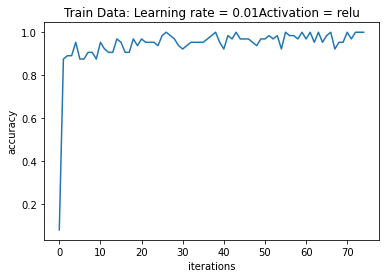

In [ ]:
plt.plot(train_acc)
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.title("Train Data: Learning rate = "  + str(learning_rate) + "Activation = "+ "relu")
plt.show()

In [ ]:
m=len(train_dataset)
train_batches=m/batch_size
# test_costs=[]
# test_accuracy=[]
# for i in range(int(test_batches)):
loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size = m ,shuffle=True)
dataiter = iter(loader)
data = next(dataiter)
X_train,y_train = data

X_train=X_train.numpy()
y_train=y_train.numpy()
# Flatten the images
image_vector_size = 28*28
X_train = X_train.reshape(X_train.shape[0], image_vector_size)
y_train_one_hot=convert_to_onehot(y_train,num_classes)
y_train_hat,out_train_cache=forward_propagation(X_train.T,trained_parameters)
#     test_costs.append(compute_cost(y_hat,y_one_hot.T))
#     test_accuracy.append(find_accuracy(y_one_hot,y_hat))
train_accuracy_final=find_accuracy(y_train_one_hot,y_train_hat)
train_cost_final=compute_cost(y_train_hat,y_train_one_hot.T)

In [ ]:
print(train_accuracy_final)

0.9799


In [ ]:
print(test_accuracy)

0.9709
